# Time Series Classification and Clustering Assignment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
def iscatter(df, x, y, color=None, size=None, title=''):
    fig = px.scatter(df, x=x, y=y, color=color, size=size, 
                     title=title, template='none')
    
    fig.update_traces(marker_line_color='black', 
                  marker_line_width=1)

    fig.show()

### Import the Walmart stock price data set (WMT_data.csv).

In [3]:
walmart = pd.read_csv('../data/WMT_data.csv')

In [4]:
walmart = walmart[['date', 'close']]
walmart.columns = ['Date', 'Observed']
walmart.head()

,Date,Observed
0,2013-02-08,71.48
1,2013-02-11,71.40
2,2013-02-12,71.40
3,2013-02-13,71.39
4,2013-02-14,70.82


### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [5]:
walmart['Returns'] = walmart['Observed'].pct_change(1)
walmart['MA_5'] = walmart['Observed'].rolling(5).mean()
walmart['MA_10'] = walmart['Observed'].rolling(10).mean()

walmart['Trend'] = 'None'
walmart.loc[walmart['MA_5'] < walmart['MA_10'], 'Trend'] = 'Negative'
walmart.loc[walmart['MA_5'] > walmart['MA_10'], 'Trend'] = 'Positive'
walmart['Change'] = walmart['Trend'].eq(walmart['Trend'].shift())

walmart['Binary'] = 0
walmart.loc[(walmart['Change']==False) & (walmart['Trend'] != 'None'), 'Binary'] = 1

walmart = walmart.dropna()
walmart.tail(10)

,Date,Observed,Returns,MA_5,MA_10,Trend,Change,Binary
1249,2018-01-25,106.60,0.007657,105.666,103.691,Positive,True,0
1250,2018-01-26,108.39,0.016792,106.426,104.528,Positive,True,0
1251,2018-01-29,109.55,0.010702,107.246,105.396,Positive,True,0
1252,2018-01-30,107.73,-0.016613,107.612,106.100,Positive,True,0
1253,2018-01-31,106.60,-0.010489,107.774,106.490,Positive,True,0
1254,2018-02-01,105.52,-0.010131,107.558,106.612,Positive,True,0
1255,2018-02-02,104.48,-0.009856,106.776,106.601,Positive,True,0
1256,2018-02-05,100.09,-0.042018,104.884,106.065,Negative,False,1
1257,2018-02-06,100.90,0.008093,103.518,105.565,Negative,True,0
1258,2018-02-07,102.85,0.019326,102.768,105.271,Negative,True,0


In [6]:
transformed = walmart[['Date', 'Returns', 'Binary']]

history = 180
future = 0

for x in range(future + 1, history + future + 1):
    transformed['t-' + str(x)] = transformed['Returns'].shift(x)
    
transformed = transformed.dropna()
transformed.head()

,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,...,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
189,2013-11-07,-0.008316,0,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,...,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993
190,2013-11-08,0.005806,0,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,...,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568
191,2013-11-11,0.013468,0,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,-0.002080,...,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512
192,2013-11-12,-0.003797,0,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,0.004169,...,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734
193,2013-11-13,0.002414,0,-0.003797,0.013468,0.005806,-0.008316,0.009558,0.001164,0.003374,...,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280


### Train a Logistic Regression classification model on the transformed data.

In [7]:
X = transformed.drop(columns=['Date', 'Returns', 'Binary'])
y = transformed['Binary']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [8]:
model = LogisticRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

### Run a classification report and evaluate the performance of the classifier.

In [9]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       195
           1       0.00      0.00      0.00        19

    accuracy                           0.91       214
   macro avg       0.46      0.50      0.48       214
weighted avg       0.83      0.91      0.87       214



### Transform the data again to have 10 days of history for clustering.

In [15]:
transformed = walmart[['Date', 'Returns', 'Binary']]

history = 10
future = 0

for x in range(future + 1, history + future + 1):
    transformed['t-' + str(x)] = transformed['Returns'].shift(x)
    
transformed = transformed.dropna()
transformed.head(30)

,Date,Returns,Binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
19,2013-03-08,-0.003955,0,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993
20,2013-03-11,-0.000685,0,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568
21,2013-03-12,0.008495,0,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512
22,2013-03-13,0.000679,0,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734
23,2013-03-14,-0.005838,0,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280
24,2013-03-15,-0.009833,1,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563
25,2013-03-18,-0.003448,0,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188
26,2013-03-19,0.002768,0,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279
27,2013-03-20,0.007453,0,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612
28,2013-03-21,0.001918,0,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818


### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [11]:
from sklearn.cluster import KMeans

def kmeans(df, clusters=2):
    model = KMeans(n_clusters=clusters, random_state=42)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['Cluster'] = clusters
    
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    
    return results, summary

In [12]:
X = transformed.drop(columns=['Date', 'Returns', 'Binary'])

In [13]:
results, summary = kmeans(X, clusters=7)
summary.head(10)

,Cluster,Count,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,172,0.000095,-0.000553,0.008348,-0.006132,-0.009410,0.005349,0.000951,0.001823,0.001317,-0.003262
1,1,134,0.003874,-0.014296,-0.001726,0.004784,-0.000043,-0.001419,-0.001053,0.003190,0.003413,0.003485
2,2,214,-0.002564,0.001321,0.001134,0.000562,0.000343,0.005405,0.001468,-0.007195,-0.000746,0.010231
3,3,191,0.010890,0.003998,-0.001678,-0.003527,0.001567,-0.004388,0.005154,-0.002466,0.000913,0.000663
4,4,212,-0.001294,0.001044,-0.004835,-0.000562,0.007753,0.003558,0.002923,0.005714,-0.007517,-0.003609
5,5,94,-0.001643,-0.001469,-0.000217,0.013131,0.000568,-0.001605,-0.001418,-0.008099,0.006539,-0.011906
6,6,223,-0.005587,0.005654,0.001553,0.001392,0.000164,-0.005252,-0.005840,0.005935,0.003443,0.000646


### Visualize the summary of the clustering results as a heatmap.

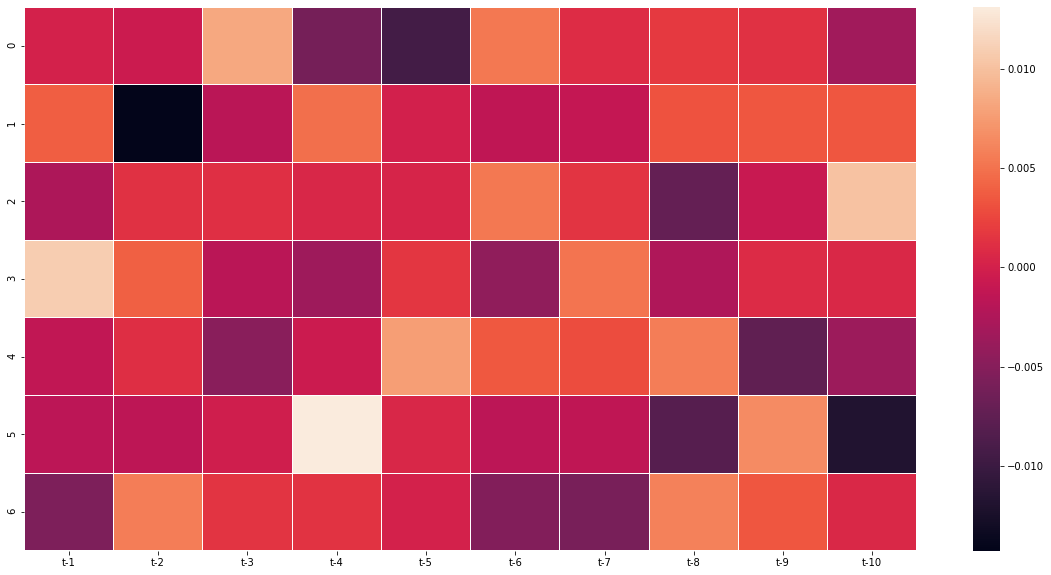

In [14]:
plt.figure(figsize=(20,10))
sns.heatmap(summary.drop(columns=['Cluster', 'Count']), linewidths=0.01)
plt.show()